<h1><center>Gotta Generate ‘Em All</center></h1>
<h3><center> A pokemon generator project using DCGAN By Will, Kiet, and Josh </center></h3>

---
---

# STEP 1: PREP WORK & VISUALIZATION FOR GAN

In [ ]:
import os
image_folder = os.path.join("..", "PokemonGenerator", "png_dataset")

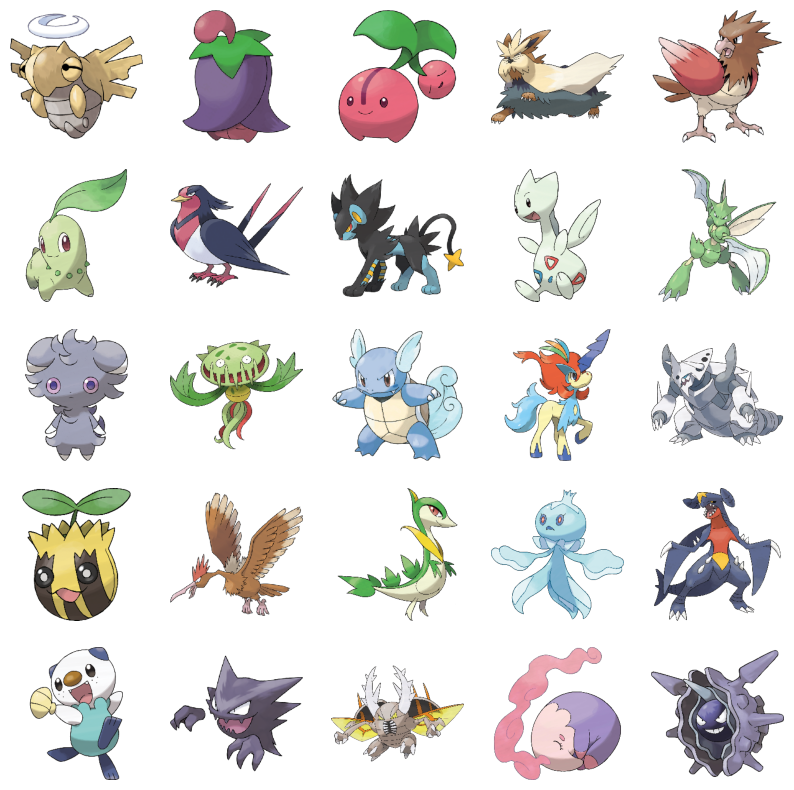

In [7]:
import random
import matplotlib.pyplot as plt
from PIL import Image

# Load image paths
image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder)]

# Randomly sample image paths
sample_size = 25
sample_paths = random.sample(image_paths, sample_size)

# Load and display images in a grid
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
axes = axes.ravel()

for i, path in enumerate(sample_paths):
    img = Image.open(path)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.show()

#First check is done, as we have started by visualizing the data to check the quality of the images

# STEP 2: DATA AUGMENTATION 

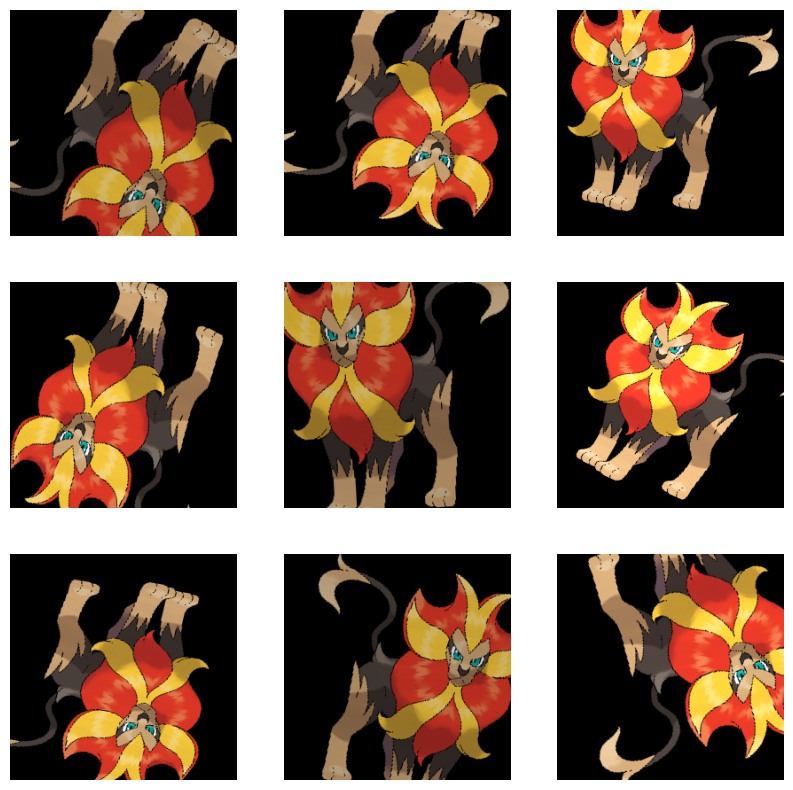

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import random

# Define the data augmentation pipeline using ImageDataGenerator
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    zoom_range=[0.8, 1.2]
)

# Load a sample image to try and preprocess it
val = random.randint(1, 721)
file = os.path.join(image_folder, str(val) +".png")
image = load_img(file)  # Load image
image = img_to_array(image)   # Convert to NumPy array
image = np.expand_dims(image, axis=0)  # Add batch dimension

# Apply data augmentation to the sample image
augmented_images = []
batch_size = 9

for batch in datagen.flow(image, batch_size=batch_size):
    augmented_images.append(batch[0])
    if len(augmented_images) >= batch_size:
        break

# Visualize the augmented images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel()

for i, img in enumerate(augmented_images):
    axes[i].imshow(img)
    axes[i].axis('off')

plt.show()

>
>**This seems to be working pretty well. When integrating this pipeline into our training process, we can replace the sample image with our entire dataset, and feed the augmented images to the GAN during training!!**
>> To do this we just need to call *datagen.flow()* on our dataset when feeding images to the GAN during training.

# STEP 3: PREPROCESS THE DATA FOR MODEL

In [54]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Conv2D, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, LeakyReLU, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from IPython import display

In [55]:
#image_folder = "../PokemonGenerator/png_dataset"
image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder)]
# Creating a list of image file paths by combining the image_folder path with the filenames of all images in the folder
# By creating a list of file paths, we can easily iterate over them and load each image in the load_image() function, which processes and prepares the images for training the GAN model

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3) # Decode PNG-encoded image data and PNG images usually have 3 color channels
    image = tf.image.resize(image, (64, 64)) # resize
    image = tf.image.random_flip_left_right(image)  # data augmentation...we can apply more if needed
    image = tf.image.convert_image_dtype(image, tf.float32) * 2.0 - 1.0
    # Converts the input image's pixel values to the range [0, 1] 
    # Then, we multiply the pixel values by 2 and subtract 1 to scale them to the range of -1 to 1
    # Normalizing the input images to the range of -1 to 1 is important since GAN uses a tanh activation function in its output layer
    # where it produces values in the range of -1 to 1.
    # This ensures that the generated images and the real images have the same value range so the discriminator to learn effectively
    return image

# Create a TensorFlow dataset from the list of image file paths
dataset = tf.data.Dataset.from_tensor_slices(image_paths)

# Map the load_image function to each image in the dataset to preprocess them
dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE) 

# Shuffle the dataset and batch the images for training the GAN
dataset = dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

# AUTOTUNE is a parameter in TensorFlow's tf.data API, 
# it allows TensorFlow to automatically determine the optimal number of parallel calls to use for data preprocessing operations
# https://www.tensorflow.org/guide/data_performance

### Outline for steps to do next: 
 #### 1. Define the generator and discriminator models, 
 #### 2. Create the generator, discriminator, and define the loss functions and optimizers
 #### 3. Define the training step function
 #### 4. Define the training loop
 #### 5. Define the function to generate and save images
 #### 6. Train the DCGAN
>
> *Once the training is complete, we can visualize the generated images and evaluate the performance of the model.*

> **Using this tutorial: https://www.tensorflow.org/tutorials/generative/dcgan**

# STEP 4: DEFINING THE GENERATOR & DISCRIMINATOR MODEL

In [56]:
import tensorflow as tf
from tensorflow.keras import layers

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 1024)))
    assert model.output_shape == (None, 4, 4, 1024)

    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# STEP 5: CREATING GENERATOR, DISCRIMINATOR AND DEFINING THE LOSS FUNCTIONS AND OPTIMIZERS

In [57]:
generator = make_generator_model()
discriminator = make_discriminator_model()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# STEP 6: DEFINING THE TRAINING STEP FUNCTION

In [58]:
@tf.function
def train_step(images):
    noise = tf.random.normal([32, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# STEP 7: DEFINING THE TRAINING LOOP

In [63]:
import time

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Save the generated images every 2 epochs
        if (epoch + 1) % 2 == 0:
            generate_and_save_images(generator, epoch + 1)

        print(f"Time for epoch {epoch + 1} is {time.time() - start} sec")

# STEP 8: DEFINING THE FUNCTION TO GENERATE AND SAVE IMAGES

In [64]:
import matplotlib.pyplot as plt
import os

def generate_and_save_images(model, epoch):
    noise = tf.random.normal([16, 100])
    generated_images = model(noise, training=False)

    fig = plt.figure(figsize=(8, 8))

    for i in range(generated_images.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((generated_images[i] + 1) / 2)
        plt.axis('off')

    plt.savefig(os.path.join("generated_images", f'image_at_epoch_{epoch:04d}.png'))
    plt.close()

# STEP 9: Training the DCGAN

In [66]:
EPOCHS = 10 # Change epochs to 100 to 200 to create pokemon

# Create a directory for the generated images if it doesn't exist
if not os.path.exists("generated_images"):
    os.makedirs("generated_images")

train(dataset, EPOCHS)


2023-04-25 13:53:13.271186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:53:13.271387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:53:13.272097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:53:13.272306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:53:13.273062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:53:13.273667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:53:13.275167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:53:13.276379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:53:13.276659: W tensorflow/core/lib/png/png_io.cc:88] PNG 

Time for epoch 1 is 45.70420718193054 sec


2023-04-25 13:53:58.981044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:53:58.981137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:53:58.982073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:53:58.982620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:53:58.983715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:53:58.983754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:53:58.989666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:53:58.989973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:53:58.991580: W tensorflow/core/lib/png/png_io.cc:88] PNG 

Time for epoch 2 is 46.74440097808838 sec


2023-04-25 13:54:45.715649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:54:45.715745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:54:45.716074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:54:45.716161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:54:45.716677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:54:45.716995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:54:45.718469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:54:45.718999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:54:45.719061: W tensorflow/core/lib/png/png_io.cc:88] PNG 

Time for epoch 3 is 47.473788022994995 sec


2023-04-25 13:55:33.198513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:55:33.199294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:55:33.200477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:55:33.200608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:55:33.200705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:55:33.201042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:55:33.204389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:55:33.208488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:55:33.208513: W tensorflow/core/lib/png/png_io.cc:88] PNG 

Time for epoch 4 is 47.414350748062134 sec


2023-04-25 13:56:20.604345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:56:20.604387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:56:20.604407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:56:20.604428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:56:20.604515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:56:20.604675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:56:20.606699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:56:20.607432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:56:20.607509: W tensorflow/core/lib/png/png_io.cc:88] PNG 

Time for epoch 5 is 47.540656089782715 sec


2023-04-25 13:57:08.153090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:57:08.154189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:57:08.155459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:57:08.156662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:57:08.157007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:57:08.160803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:57:08.162789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:57:08.163201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:57:08.163244: W tensorflow/core/lib/png/png_io.cc:88] PNG 

Time for epoch 6 is 49.3391969203949 sec


2023-04-25 13:57:57.485912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:57:57.485981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:57:57.486190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:57:57.486323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:57:57.486708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:57:57.487427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:57:57.488843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:57:57.489303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:57:57.489371: W tensorflow/core/lib/png/png_io.cc:88] PNG 

Time for epoch 7 is 50.354896068573 sec


2023-04-25 13:58:47.850192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:58:47.851352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:58:47.852733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:58:47.852799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:58:47.853445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:58:47.856722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:58:47.859207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:58:47.859225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:58:47.861180: W tensorflow/core/lib/png/png_io.cc:88] PNG 

Time for epoch 8 is 46.313063859939575 sec


2023-04-25 13:59:34.152674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:59:34.152703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:59:34.152722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:59:34.152738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:59:34.152759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:59:34.152779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:59:34.154626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:59:34.155083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 13:59:34.155220: W tensorflow/core/lib/png/png_io.cc:88] PNG 

Time for epoch 9 is 45.503211975097656 sec


2023-04-25 14:00:19.664482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 14:00:19.664646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 14:00:19.666149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 14:00:19.667585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 14:00:19.669552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 14:00:19.671116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 14:00:19.672952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 14:00:19.673378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-25 14:00:19.673458: W tensorflow/core/lib/png/png_io.cc:88] PNG 

Time for epoch 10 is 48.827537059783936 sec



## Below is what Will did to start off, I did not touch it yet.

In [1]:
from tensorflow.keras import layers, losses
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU, Dropout

2023-04-19 12:13:58.094318: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


For our first pass through we are basing our model on one found here
https://medium.com/mlearning-ai/image-generation-using-generative-adversarial-networks-gans-cd82afd71597

In [ ]:
class GAN:  
    def __init__(self, shape):
        self.input_shape = shape
        self.generator = Sequential(
            Dense(256, input_dim=input_shape),
            LeakyReLU(0.2),
            Dense(512),
            LeakyReLU(0.2),
            Dense(1024),
            LeakyReLU(0.2),
            Dense(output_shape, activation='tanh')
        )
        
        self.discriminator = Sequential(
            Dense(1024, input_dim=output_shape),
            LeakyReLU(0.2),
            Dropout(0.2),
            Dense(512),
            LeakyReLU(0.2),
            Dropout(0.2),
            Dense(256),
            LeakyReLU(0.2),
            Dense(1, activation='sigmoid')
        )